In [8]:
import cupy as cp
import cupyx
import scanpy as sc
import numpy as np
import pandas as pd
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image
from sklearn.linear_model import LinearRegression
import pickle
import pickle
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
from libpysal.weights import W
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns 
from scipy.sparse import csr_matrix
import pickle

In [9]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"
FilePrefix = "_072824" 

In [10]:
grid = sc.read_h5ad(os.path.join(pathout, "grid_save.h5ad"))
file_path = os.path.join(pathout, "grid_uns_mtracies.pkl")

if os.path.getsize(file_path) > 0:
    with open(file_path, 'rb') as buff:
        grid_uns_mtracies = pickle.load(buff)
else:
    print("File is empty. Cannot load data.")
    grid_uns_mtracies = None
grid.uns = {}
grid.uns['cluster'] = pd.read_csv(os.path.join(pathout, "cluster.csv"))
grid.uns['grid_counts'] = grid_uns_mtracies['grid_counts']
grid.uns['grid_xedges'] = grid_uns_mtracies['grid_xedges']
grid.uns['grid_yedges'] = grid_uns_mtracies['grid_yedges']
grid.uns['lrfeatures'] = pd.read_csv(os.path.join(pathout, "lrfeatures.csv"))
grid.uns['lr_summary'] = pd.read_csv(os.path.join(pathout, "lr_summary.csv"))
sparse_matrix = grid.X
row_sums = sparse_matrix.sum(axis=1)
grid.obs['n_counts'] = np.array(row_sums).flatten()

In [11]:
grid.layers['counts'] = grid.X.copy()
sc.pp.normalize_total(grid)
sc.pp.log1p(grid)
grid.layers['log'] = grid.X.copy()
sc.pp.scale(grid, max_value=10)

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy-voyagerpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


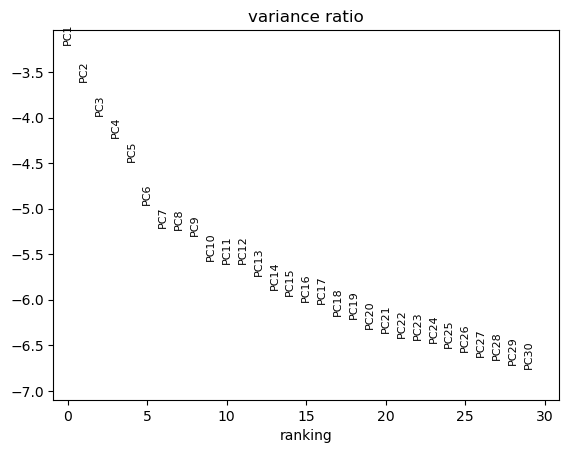

In [12]:
sc.tl.pca(grid, use_highly_variable=False, n_comps=30, random_state=1337)
sc.pl.pca_variance_ratio(grid, log=True, n_pcs=30)

In [13]:
from libpysal.graph import Graph

In [14]:
from libpysal.weights.util import lat2W

In [19]:
lat2W(np.random.randint(1,9,9).reshape(3,3))

TypeError: only integer scalar arrays can be converted to a scalar index

In [21]:
arr = grid.obs['cluster'].to_numpy().astype(int)
neighbors = {}
weights = {}
for i,a in enumerate(arr):
    neighbors[i] = np.where(arr == a)[0].tolist()
    if i in neighbors[i]:
        neighbors[i].remove(i)
    weights[i] = [1] * len(neighbors[i])
from libpysal.weights import W
w = W(neighbors, weights)
w.transform = 'r'

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy-voyagerpy/lib/python3.8/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 15 disconnected components.
  warnings.warn(message)


In [34]:
w = W(neighbors, weights)

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy-voyagerpy/lib/python3.8/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 15 disconnected components.
  warnings.warn(message)


In [39]:
ligand_values = grid.layers['log'][:,grid.var_names=="BTLA"]
ligand_values = np.nan_to_num(ligand_values, nan=0.0)
ligand_values_lag = lps.weights.lag_spatial(w, ligand_values)
# receptor_values = grid.layers['log'][:,grid.var_names=="CD79A"]
# receptor_values = np.nan_to_num(receptor_values, nan=0.0)
clusters = grid.obs['cluster'].values
x = grid.obsm['spatial'][:, 0]
y =  grid.obsm['spatial'][:, 1]


In [40]:
ligand_values[:,-1].shape

(35389,)

In [41]:
df  = pd.DataFrame({'cluster':clusters,"x":x,"y":y,"n_counts":ligand_values[:,-1],"n_counts_lag":ligand_values_lag[:,-1]})

<Axes: xlabel='n_counts', ylabel='n_counts_lag'>

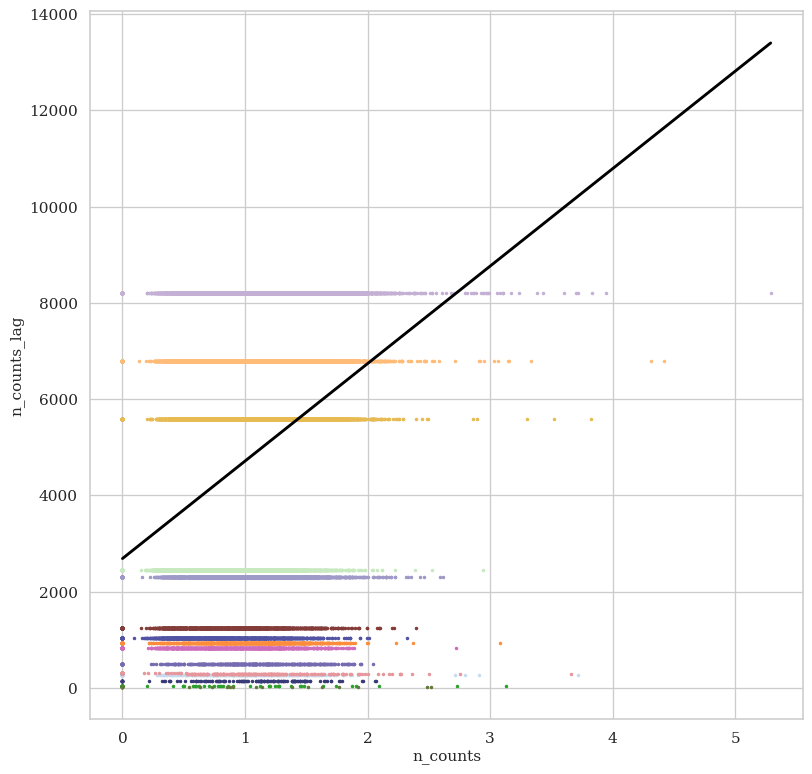

In [42]:
import pickle
file_path = os.path.join(pathout, "andata_uns_mtracies.pkl")
with open(file_path, 'rb') as buff:
    andata_uns_mtracies = pickle.load(buff)
clusterColorMap = andata_uns_mtracies['clusterColorMap']
clusters = sorted(np.unique(df['cluster'].values), key=int)
sns.set_theme(style="whitegrid")
palette = clusterColorMap.sort_index()['colors'].to_list()
plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, cluster in enumerate(clusters):
    cluster_grid = df[df['cluster'] == cluster]
    ax.scatter(x=cluster_grid['n_counts'], y=cluster_grid['n_counts_lag'], color=palette[i], label=f'{cluster}', s=3, alpha=1)
sns.regplot(data=df, x=df['n_counts'], y=df['n_counts_lag'],color= 'black',scatter_kws={'s': 0},ci = None,ax= ax)

In [5]:
from libpysal.weights import lat2W

In [7]:
w9 = lat2W(3,3)
"%.3f"%w9.pct_nonzero

'29.630'

In [3]:

libpysal.weights.lat2W(3, 3)

NameError: name 'libpysal' is not defined

In [ ]:
w = libpysal.weights.lat2W(3, 3)